<h1 style="color:black; margin-bottom:20px">Описание проекта</h1><br>
Стартап продаёт продукты питания. Нужно разобраться, как ведут себя пользователи мобильного приложения.<br>
    
Необходимо изучить воронку продаж. Узнать, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?<br>
    
После этого исследовать результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Надо выяснить, какой шрифт лучше.<br>
    
Создание двух групп A вместо одной имеет определённые преимущества. Если две контрольные группы окажутся равны, можно быть уверенным в точности проведенного тестирования. Если же между значениями A и A будут существенные различия, это поможет обнаружить факторы, которые привели к искажению результатов. Сравнение контрольных групп также помогает понять, сколько времени и данных потребуется для дальнейших тестов.<br>
    
<h1 style="color:black; margin-bottom:20px">Описание данных</h1><br>
Каждая запись в логе — это действие пользователя, или событие.<br>

- EventName — название события;
- DeviceIDHash — уникальный идентификатор пользователя;
- EventTimestamp — время события;
- ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

# Шаг 1. Загрузка данных.

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import scipy.stats as stats
from scipy import stats as st
import math as mth
import plotly.express as px
from plotly import graph_objects as go

In [2]:
data = pd.read_csv('/datasets/logs_exp.csv', delimiter='\t')

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


# Шаг 2. Подготовка данных

In [12]:
# приведение названий столбцов к нижнему регистру. Удаление пробелов
data = data.rename(columns={'EventName': 'event_name', 
                            'DeviceIDHash': 'device_id', 
                            'EventTimestamp': 'event_time', 
                            'ExpId': 'exp_id'})

In [8]:
# проверка на наличие дубликатов
print('Дубликатов:', data.duplicated().sum())

# проверка на наличие пропусков
display('Пропусков в столбцах:', data.isna().sum())

Дубликатов: 413


'Пропусков в столбцах:'

EventName         0
DeviceIDHash      0
EventTimestamp    0
ExpId             0
dtype: int64

Пропусков нет.<br>
Дубликатов 413 строк, что составляет всего 0,17%. Дубликаты просто удаляем.

In [10]:
# удаление дубликатов
data = data.drop_duplicates()

In [13]:
# перевод столбца в типа data
data['event_time'] = pd.to_datetime(data['event_time'], unit='s')

# добавление нового столбца
data['date_new'] = data['event_time']

# добавление отдельного столбца дат
data['data'] = data['event_time'].dt.date

# Шаг 3. Изучение и проверка данных
### Сколько всего событий в логе?
### Сколько всего пользователей в логе?
### Сколько в среднем событий приходится на пользователя?

In [31]:
print('Типов событий в логе:',data['event_name'].nunique())
print('Количество событий:',len(data))
display('Типы событий и их количество:', data.groupby('event_name')['device_id'].count())
print('--------------------------------------------------------------------------------------')
print('Пользователей в логе:', data['device_id'].nunique())
print('В среднем приходится на пользователя ', round(len(data)/data['device_id'].nunique(), 2), 'событий')

Типов событий в логе: 5
Количество событий: 243713


'Типы событий и их количество:'

event_name
CartScreenAppear            42668
MainScreenAppear           119101
OffersScreenAppear          46808
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: device_id, dtype: int64

--------------------------------------------------------------------------------------
Пользователей в логе: 7551
В среднем приходится на пользователя  32.28 событий


### Данные за какой период имеются? Надо найти максимальную и минимальную дату. Построить гистограмму по дате и времени.

In [33]:
print('Минимальная дата:', data['event_time'].min())
print('Максимальная дата:', data['event_time'].max())

# подсчет количества дат в данных для подсчета корзин в гистограмме
print('Количества дат в данных:', data['data'].nunique())

Минимальная дата: 2019-07-25 04:43:36
Максимальная дата: 2019-08-07 21:15:17
Количества дат в данных 14


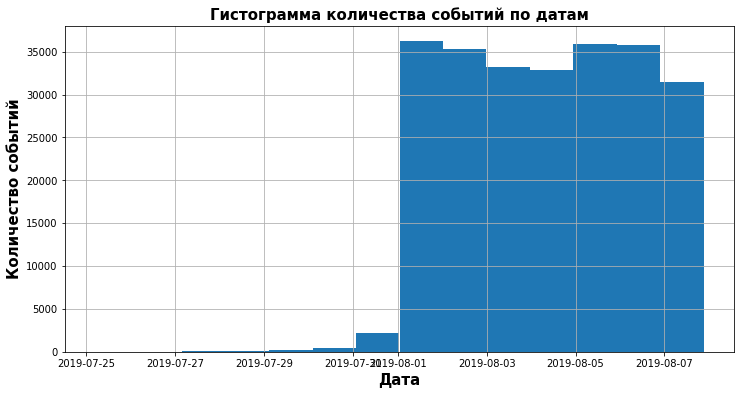

In [35]:
# построение гистограммы
plt.figure(figsize=(12, 6))
plt.hist(data['event_time'], bins=14)
plt.xlabel('Дата', fontsize=15, fontweight='bold')
plt.ylabel('Количество событий', fontsize=15, fontweight='bold')
plt.title('Гистограмма количества событий по датам', fontsize=15, fontweight='bold')
plt.grid()
plt.show() 

### Можно ли быть уверенным, что имеются одинаково полные данные за весь период? Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». Надо определить, с какого момента данные полные и отбросить более старые. 


In [36]:
# подсчет количества событий по датам
data.groupby('data')['event_name'].count()

data
2019-07-25        9
2019-07-26       31
2019-07-27       55
2019-07-28      105
2019-07-29      184
2019-07-30      412
2019-07-31     2030
2019-08-01    36141
2019-08-02    35554
2019-08-03    33282
2019-08-04    32968
2019-08-05    36058
2019-08-06    35788
2019-08-07    31096
Name: event_name, dtype: int64

Из гистограммы и подсчета количества по датам видно, что с 1-го числа августа месяца 2019 года мы видим резкое увеличение количества событий.<br>
Имеет смысл отфильтровать данные с 01.08.2019.<br>
В августе количество событий по датам стабильно с 31 до 36 тысяч штук в день.<br>
Можно считать, что данные "доехали"

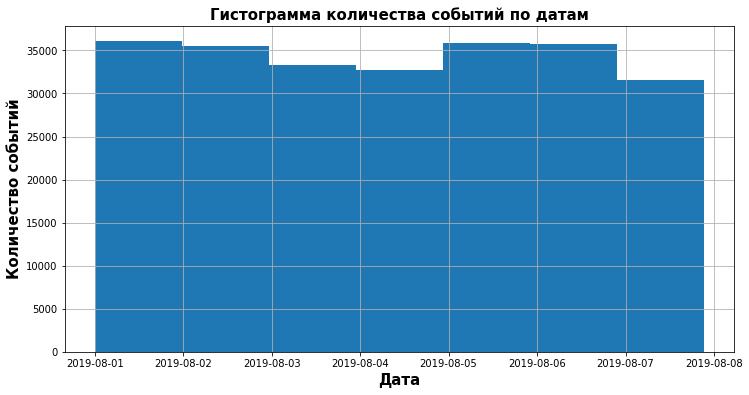

In [38]:
# построение гистограммы
data_f = data.query('event_time > "2019-08-01 00:00:00"')
plt.figure(figsize=(12, 6))
plt.hist(data_f['event_time'], bins=7)
plt.xlabel('Дата', fontsize=15, fontweight='bold')
plt.ylabel('Количество событий', fontsize=15, fontweight='bold')
plt.title('Гистограмма количества событий по датам', fontsize=15, fontweight='bold')
plt.grid()
plt.show() 

### Много ли событий и пользователей потеряли, отбросив старые данные?

In [43]:
print(F"Осталось {round(len(data_f) / len(data) * 100, 2)} % событий")
print(F"Осталось {round(data_f['device_id'].nunique() / data['device_id'].nunique() * 100, 2)} % пользователей")
print(F"Удалено {len(data) - len(data_f)} строк")

# проверка остатка количества пользователей из всех трёх экспериментальных групп.
display('Осталось по группам в процентах:', round(data_f.groupby('exp_id')['event_name'].count()/
                      data.groupby('exp_id')['event_name'].count()*100, 2))

Осталось 98.84 % событий
Осталось 99.77 % пользователей
Удалено 2826 строк


'Осталось по группам в процентах:'

exp_id
246    98.90
247    98.81
248    98.81
Name: event_name, dtype: float64

# Шаг 4. Изучение воронки событий
### Какие события есть в логах и как часто они встречаются? Сортировка события по частоте.

In [47]:
print('Типов событий в логе:',data_f['event_name'].nunique())
print('--------------------------------------------------------------------------------------')
print('Типы событий:',data_f['event_name'].unique())
print('--------------------------------------------------------------------------------------')

# сортировка по частоте событий
display('Сортировка по частоте событий', data_f['event_name'].value_counts())
print('--------------------------------------------------------------------------------------')

# сортировка в процентах по частоте событий
display('Сортировка в процентах по частоте событий', round(data_f['event_name'].value_counts()/len(data_f)*100, 2))

Типов событий в логе: 5
--------------------------------------------------------------------------------------
Типы событий: ['Tutorial' 'MainScreenAppear' 'OffersScreenAppear' 'CartScreenAppear'
 'PaymentScreenSuccessful']
--------------------------------------------------------------------------------------


'Сортировка по частоте событий'

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_name, dtype: int64

--------------------------------------------------------------------------------------


'Сортировка в процентах по частоте событий'

MainScreenAppear           48.71
OffersScreenAppear         19.23
CartScreenAppear           17.56
PaymentScreenSuccessful    14.08
Tutorial                    0.42
Name: event_name, dtype: float64

В логах всего 5 событий.<br>
Чаще всего происходит MainScreenAppear - более 48%.<br>
Реже всего происходит Tutorial - менее 0,5%

### Сколько пользователей совершали каждое из этих событий? Какова доля пользователей, которые хоть раз совершали событие?

In [60]:
# сортировка количества пользователей совершивших событие
data_vor = pd.pivot_table(data_f,
               index=["event_name"],
               values=["device_id"],
               aggfunc={'device_id': 'nunique'}).sort_values(by='device_id', ascending=False).reset_index()

# подсчет доли пользователей совершивших события в процентах
data_vor['dev_id_to_all'] = round(data_vor['device_id'] / data_f['device_id'].nunique() * 100, 2)
data_vor = data_vor.rename(columns={'event_name': 'Название события',
                                    'device_id': 'Количество пользователей, совершивших событие',
                                    'dev_id_to_all': 'Количество в %'})
display('Количество пользователей совершивших событие', data_vor)

'Количество пользователей совершивших событие'

,Название события,"Количество пользователей, совершивших событие",Количество в %
0,MainScreenAppear,7419,98.47
1,OffersScreenAppear,4593,60.96
2,CartScreenAppear,3734,49.56
3,PaymentScreenSuccessful,3539,46.97
4,Tutorial,840,11.15


Из полученных данных следует, что не все пользователи начинали с главного экрана. Вероятно они по ссылке из поисковика переходили сразу на страницу предложений. В таком случае имеет смысл считать переходящих на страницу предложений от общего количества пользователей.<br>
Поле Tutorial в воронке продаж не участвует. На него могут переходить в любой момент. <br>
Поэтому воронка выглядит так:<br>
Все пользователи --> OffersScreenAppear --> CartScreenAppear --> PaymentScreenSuccessful<br>
      100%       -->         60.98%     -->       49.56      -->         46.96

In [52]:
events = data_f[data_f['event_name'] != 'Tutorial']['event_name'].unique()
events

array(['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear',
       'PaymentScreenSuccessful'], dtype=object)

### По воронке событий необходимо посчитать, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем).

In [55]:
# вычисление воронки
data_vor['vor'] = round(data_vor['Количество пользователей, совершивших событие'] / data_vor['Количество пользователей, совершивших событие'].shift(1,fill_value=0) * 100, 2)
data_vor.drop(labels = 4 ,axis = 0)

,Название события,"Количество пользователей, совершивших событие",Количество в %,vor
0,MainScreenAppear,7419,98.47,inf
1,OffersScreenAppear,4593,60.96,61.91
2,CartScreenAppear,3734,49.56,81.30
3,PaymentScreenSuccessful,3539,46.97,94.78


Из полученных данных следует, что на первом шаге теряется больше всего пользователей. До оплаты доходит 46%

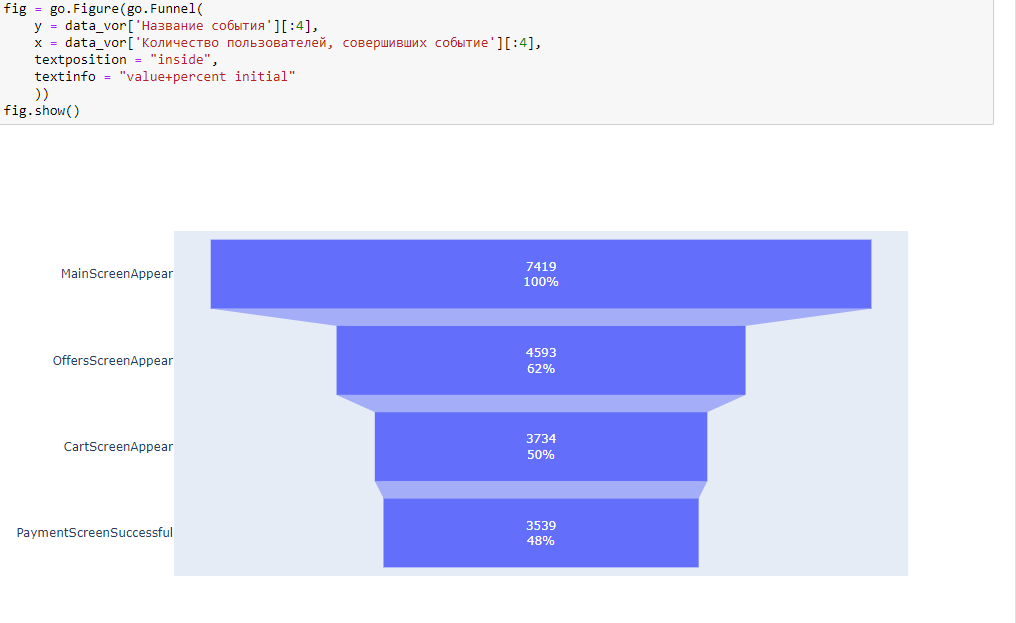

# Шаг 5. Изучение результатов эксперимента

In [62]:
# подсчет количества пользователей и событий в группах
groups = data_f.groupby('exp_id').agg(users=('device_id', 'nunique'), 
                                      events=('event_name','count'))
groups

,users,events
exp_id,,
246,2484,79302
247,2513,77022
248,2537,84563


In [63]:
# проверка количества уникальных значений в столбце с номером группы
control_d = data_f.groupby('device_id').agg({'event_name': 'count', 'exp_id': 'nunique'})
control_d['exp_id'].unique()

array([1], dtype=int64)

Совпадающих групп по пользователям не обнаружено.

### Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Надо проверить, находят ли статистические критерии разницу между выборками 246 и 247.

In [64]:
# создание таблицы с данными по группам
group_info = pd.pivot_table(data_f,
                           index=['event_name'],
                           columns='exp_id',
                           values='device_id',
                           aggfunc='nunique').sort_values(by=246,ascending=False)

# избавляемся от ненужного события
group_info = group_info[group_info.index != 'Tutorial']

# объединение с транспонированной таблицей по группам в целом
group_info = pd.concat([group_info, groups.T])

# вычисление суммы для контрольных групп 
group_info['246+247'] = group_info[246] + group_info[247]

group_info

exp_id,246,247,248,246+247
MainScreenAppear,2450,2476,2493,4926
OffersScreenAppear,1542,1520,1531,3062
CartScreenAppear,1266,1238,1230,2504
PaymentScreenSuccessful,1200,1158,1181,2358
users,2484,2513,2537,4997
events,79302,77022,84563,156324


Самым популярным событием является MainScreenAppear.<br>
Его совершили 98% пользователей во всех группах.

In [65]:
# подсчет количества пользователей в контрольных группах в событии MainScreenAppear
for i in [246, 247]:
    print(f"Количество пользователей в группе {i}: {group_info[i]['MainScreenAppear']}")
    
# подсчет доли пользователей, совершивших событие MainScreenAppear в контрольных группах 
for i in [246, 247]:
    print(f"Доля пользователей группы {i}: {round(group_info[i]['MainScreenAppear'] / group_info[i]['users']*100, 2)}%")

Количество пользователей в группе 246: 2450
Количество пользователей в группе 247: 2476
Доля пользователей группы 246: 98.63%
Доля пользователей группы 247: 98.53%


### Надо проверить, будет ли отличие между группами статистически достоверным. Затем проделать то же самое для всех других событий (удобно обернуть проверку в отдельную функцию). 

In [66]:
def funk_calk(alpha, gr1, gr2, event):
    alpha = alpha # критический уровень статистической значимости

    # пропорция успехов в первой группе:
    p1 = group_info[gr1][event] / group_info[gr1].users

    # пропорция успехов во второй группе:
    p2 = group_info[gr2][event] / group_info[gr2].users

    # пропорция успехов в комбинированном датасете:
    p_combined = (group_info[gr1][event] + group_info[gr2][event]) / (group_info[gr1].users + group_info[gr2].users)

    # разница пропорций в датасетах
    difference = p1 - p2 
    
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/group_info[gr1].users + 1/group_info[gr2].users))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)  
    
    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между группами есть значимая разница')
    else:
        print(
            'Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными'
        ) 

### Гипотезы:
Нулевая: различие в конверсиях между контрольными группами отсутствует.<br>
Альтернативная: различие в конверсиях между контрольными группами статистически достоверно.

In [68]:
gr1 = 246
gr2 = 247
alpha = 0.01

for event in events:
    print(f"Для групп {gr1} и {gr2} и события {event} получилось следующее:")
    funk_calk(alpha, gr1, gr2, event)
    print('-----------------------------------------------------------------------------------')

Для групп 246 и 247 и события MainScreenAppear получилось следующее:
p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными
-----------------------------------------------------------------------------------
Для групп 246 и 247 и события OffersScreenAppear получилось следующее:
p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными
-----------------------------------------------------------------------------------
Для групп 246 и 247 и события CartScreenAppear получилось следующее:
p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными
-----------------------------------------------------------------------------------
Для групп 246 и 247 и события PaymentScreenSuccessful получилось следующее:
p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными
-------------

По полученным данным нет причин считать, что разбиение на группы не корректно.

### Аналогично надо поступить с группой с изменённым шрифтом.
Затем сравнить результаты с каждой из контрольных групп в отдельности по каждому событию.
### Гипотезы:
Нулевая: различие в конверсиях между контрольной группой 246 и группой 248 отсутствует.
Альтернативная: различие в конверсиях между контрольной группой 246 и группой 248 статистически достоверно.

In [69]:
gr1 = 246
gr2 = 248
alpha = 0.01

for event in events:
    print(f"Для групп {gr1} и {gr2} и события {event} получилось следующее:")
    funk_calk(alpha, gr1, gr2, event)
    print('-----------------------------------------------------------------------------------')

Для групп 246 и 248 и события MainScreenAppear получилось следующее:
p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными
-----------------------------------------------------------------------------------
Для групп 246 и 248 и события OffersScreenAppear получилось следующее:
p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными
-----------------------------------------------------------------------------------
Для групп 246 и 248 и события CartScreenAppear получилось следующее:
p-значение:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными
-----------------------------------------------------------------------------------
Для групп 246 и 248 и события PaymentScreenSuccessful получилось следующее:
p-значение:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными
-------------

### Гипотезы:
Нулевая: различие в конверсиях между контрольной группой 247 и группой 248 отсутствует.
Альтернативная: различие в конверсиях между контрольной группой 247 и группой 248 статистически достоверно.

In [70]:
gr1 = 247
gr2 = 248
alpha = 0.01

for event in events:
    print(f"Для групп {gr1} и {gr2} и события {event} получилось следующее:")
    funk_calk(alpha, gr1, gr2, event)
    print('-----------------------------------------------------------------------------------')

Для групп 247 и 248 и события MainScreenAppear получилось следующее:
p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными
-----------------------------------------------------------------------------------
Для групп 247 и 248 и события OffersScreenAppear получилось следующее:
p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными
-----------------------------------------------------------------------------------
Для групп 247 и 248 и события CartScreenAppear получилось следующее:
p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными
-----------------------------------------------------------------------------------
Для групп 247 и 248 и события PaymentScreenSuccessful получилось следующее:
p-значение:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными
---------------

### Гипотезы:
Нулевая: различие в конверсиях между объединенной контрольной группой и группой 248 отсутствует.
Альтернативная: различие в конверсиях между объединенной контрольной группой и группой 248 статистически достоверно.

In [71]:
gr1 = '246+247'
gr2 = 248
alpha = 0.01

for event in events:
    print(f"Для групп {gr1} и {gr2} и события {event} получилось следующее:")
    funk_calk(alpha, gr1, gr2, event)
    print('-----------------------------------------------------------------------------------')

Для групп 246+247 и 248 и события MainScreenAppear получилось следующее:
p-значение:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными
-----------------------------------------------------------------------------------
Для групп 246+247 и 248 и события OffersScreenAppear получилось следующее:
p-значение:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными
-----------------------------------------------------------------------------------
Для групп 246+247 и 248 и события CartScreenAppear получилось следующее:
p-значение:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными
-----------------------------------------------------------------------------------
Для групп 246+247 и 248 и события PaymentScreenSuccessful получилось следующее:
p-значение:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разн

Оснований считать выбор групп не верным нет. Существенных различий в группах не выявлено.<br>
Было выполнено 16 проверок статистически гипотез.<br>
Считаю выбор alpha=0.01 потимальным для этого проекта.

# Шаг 6. Выводы
В Шаге 3 были изучены полученные данные на предмет правильности к поставленной задаче. Был выявлен актуальный диапазон исследуемых дат.<br>
В Шаге 4 была изучена воронка событий. Для дальнейшего исследования была отвергнута часть событий.<br>
В Шаге 5 были изучены результаты эксперимента. Проведено сравнение контрольных групп между собой, контрольных групп с экспериментальной и сборной контрольной группы с экспериментальной.<br>
Оснований считать выбор групп не верным нет. Существенных различий в группах не выявлено.